## Use our trained models
The models used for our final setup can be found in `pfns4bo/final_models`.
We assume you are one level above `pfns4bo`.


### Use on discrete benchmarks
To use our model on discrete benchmarks, we recommend using our HPO-B interface `pfns4bo.scripts.acquisition_functions.TransformerBOMethod`.

We called this interface like this for the eval's on HPO-B:

In [1]:
import torch
import pfns4bo
from pfns4bo.scripts.acquisition_functions import TransformerBOMethod
from pfns4bo.scripts.tune_input_warping import fit_input_warping

# ~~~might need to change these~~~
folder_with_models = pfns4bo.__path__[0] + '/final_models/'
device = 'cpu:0'

# For HEBO+ 
model_name = 'model_hebo_morebudget_9_unused_features_3.pt'
# For BNN
#model_name = 'model_sampled_warp_simple_mlp_for_hpob_46.pt'

# for correctly specified search spaces (e.g. correctly applied log transformations)
pfn_bo = TransformerBOMethod(torch.load(folder_with_models + model_name), device=device)

# for mis-specified search spaces
#pfn_bo = TransformerBOMethod(torch.load(folder_with_models + model_name), fit_encoder=fit_input_warping, device=device)


The interface expects all features to be normalized to a [0,1] range and all features have to be scalars/floats.


In [50]:
X_obs = torch.rand(10,1) # n_examples x n_feats
y_obs = X_obs[:,0]*.2 + torch.randn_like(X_obs[:,0]) * .01 # n_examples
X_pen = torch.linspace(0,1,1000)[:,None] # n_pending x n_feats

Now that we have data, we can calculate our acquisition like this:

In [51]:
rec_idx, eis = pfn_bo.observe_and_suggest(X_obs=X_obs, y_obs=y_obs, X_pen=X_pen, return_actual_ei=True)

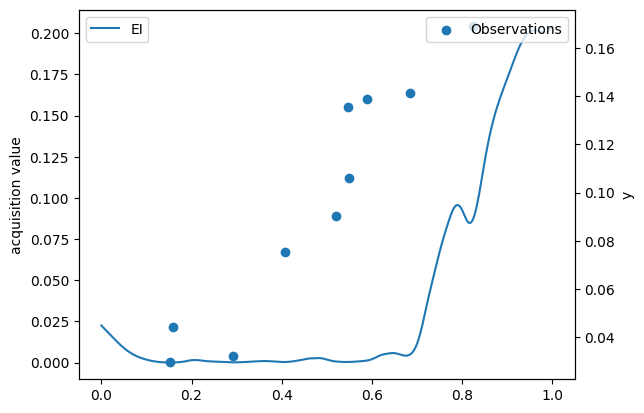

In [52]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(X_pen, eis, label='EI')

ax1.set_ylabel('acquisition value')

ax1.legend(loc=0)

ax2 = ax1.twinx()

ax2.scatter(X_obs, y_obs, label='Observations')
ax2.set_ylabel('y')


ax2.legend(loc=1)
plt.show()


### We can use another acquisition function
Just specify `acq_function='pi'` or `acq_function='ucb'`.


In [53]:
pfn_bo_pi = TransformerBOMethod(torch.load(folder_with_models + model_name), device=device, acq_function='pi')
rec_idx_pi, pis = pfn_bo_pi.observe_and_suggest(X_obs=X_obs, y_obs=y_obs, X_pen=X_pen, return_actual_ei=True)

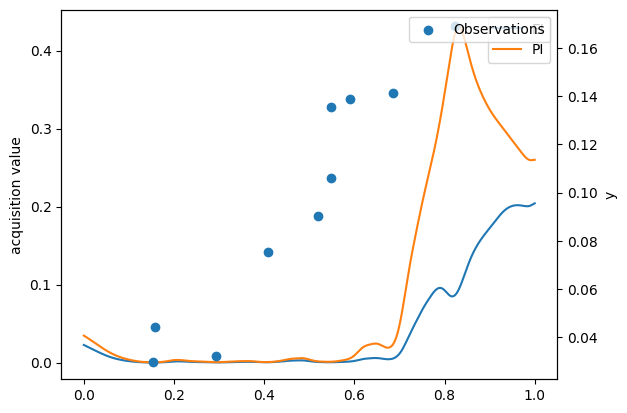

In [54]:
fig, ax1 = plt.subplots()

ax1.plot(X_pen, eis, label='EI')
ax1.plot(X_pen, pis, label='PI')

ax1.set_ylabel('acquisition value')

ax1.legend(loc=0)

ax2 = ax1.twinx()

ax2.scatter(X_obs, y_obs, label='Observations')
ax2.set_ylabel('y')


ax2.legend(loc=1)
plt.show()

You can even set `acq_function='mean'` to get the mean, by default we use a power transforms on y's though, so it might look a little different than expected.

In [55]:
pfn_bo_mean = TransformerBOMethod(torch.load(folder_with_models + model_name), device=device, acq_function='mean', apply_power_transform=False)
rec_idx_mean, means = pfn_bo_mean.observe_and_suggest(X_obs=X_obs, y_obs=y_obs, X_pen=X_pen, return_actual_ei=True)

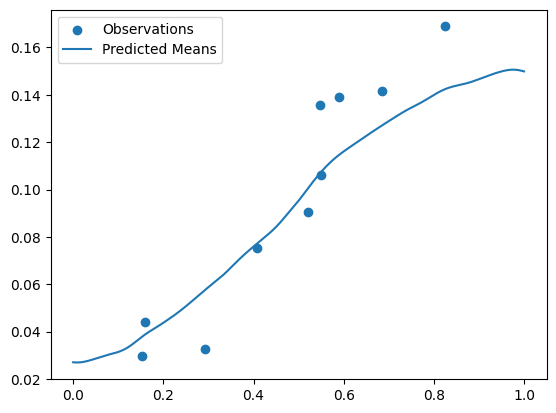

In [56]:

plt.scatter(X_obs, y_obs, label='Observations')
plt.plot(X_pen, means, label='Predicted Means')


plt.legend()
plt.show()

### Use user priors



In [63]:
model_path = folder_with_models + 'hebo_morebudget_9_unused_features_3_userpriorperdim2_8.pt'
# the order of hps in our benchmark is 'lr_decay_factor', 'lr_initial', 'lr_power', 'opt_momentum', 'epoch', 'activation'
pfn_bo_w_userprior = TransformerBOMethod(torch.load(model_path), style=\
                     torch.tensor([
                         .9, 0/4, 1/4, # feature 1 has .9 prob is given to the prior where all max's lie in [0,.25], (1-.9) to be anywhere in [0,1]
                     ]).view(1,-1)
)

In [64]:
rec_idx_w_userprior, eis_w_userprior = pfn_bo_w_userprior.observe_and_suggest(X_obs=X_obs, y_obs=y_obs, X_pen=X_pen, return_actual_ei=True)

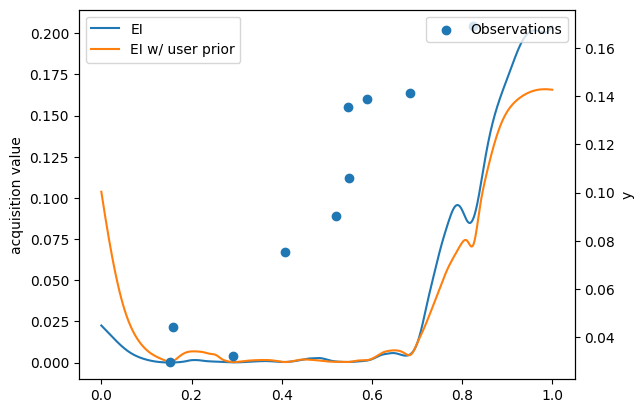

In [65]:
fig, ax1 = plt.subplots()

ax1.plot(X_pen, eis, label='EI')
ax1.plot(X_pen, eis_w_userprior, label='EI w/ user prior')
ax1.set_ylabel('acquisition value')

ax1.legend(loc=0)

ax2 = ax1.twinx()

ax2.scatter(X_obs, y_obs, label='Observations')
ax2.set_ylabel('y')


ax2.legend(loc=1)
plt.show()